In [38]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline, DistilBertTokenizer

importlib.reload(utils)

<module 'utility_functions' from '/Users/borosabel/Documents/Uni/Thesis/PopMusicInformationRetrieval/utility_functions.py'>

In [23]:
data = './Data/dataframes/preprocessed_df.pkl'
df = pd.read_pickle(data)

In [24]:
df[['Artist', 'Song', 'Tokens', 'Lyrics', 'Coast']].head()

,Artist,Song,Tokens,Lyrics,Coast
0,Big L,8 Iz Enuff.mp3,"[crew, house, bless, big, mike, imma, set, fol...","\n\nYo\nMy crew is in the house\nTerra, Herb M...",east_coast
1,Big L,Da Graveyard.mp3,"[number, one, crew, big, nigga, men, win, kill...",\n\n[Intro:]\nIt's the number one crew in the ...,east_coast
2,Big L,I Don't Understand It.mp3,"[many, mcs, ask, even, supposed, make, rap, kn...",\n\n[Verse 1]\nThere are too many MC's who are...,east_coast
3,Big L,"No Endz, No Skinz.mp3","[let, point, real, quick, pocket, thick, mad, ...",\n\n[Verse 1:]\nLet me get to the point real q...,east_coast
4,Big L,MVP.mp3,"[pass, make, quick, money, grip, ass, street, ...",\n\n[Big L]\n A yo spark up the phillies and p...,east_coast


In [40]:
def get_sentiment(tokens):
    max_length = 512
    chunk_overlap = 50

    # Use the provided tokens directly instead of tokenizing
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length - chunk_overlap)]

    all_scores = []

    for chunk in chunks:
        # Convert tokens to text
        chunk_text = tokenizer.convert_tokens_to_string(chunk)

        # Get sentiment for each chunk, use truncation and padding to handle input size
        results = classifier(chunk_text, truncation=True, max_length=max_length, padding='max_length')

        # Append scores for each emotion
        for result in results:
            all_scores.append({emotion['label']: emotion['score'] for emotion in result})

    # Aggregate scores across chunks
    aggregated_scores = {}
    for score_dict in all_scores:
        for emotion, score in score_dict.items():
            if emotion in aggregated_scores:
                aggregated_scores[emotion] += score
            else:
                aggregated_scores[emotion] = score

    # Average the scores
    num_entries = len(all_scores)
    aggregated_scores = {emotion: score / num_entries for emotion, score in aggregated_scores.items()}

    return aggregated_scores

In [41]:
print("Calculating emotion scores for preprocessed tokens (Tokens column)...")
df['tokens_emotion_scores'] = df['Tokens'].progress_apply(lambda tokens: get_sentiment(tokens))

# Convert the dictionary column into separate columns for each emotion
emotion_columns = ["anger", "joy", "love", "fear", "surprise", "sadness"]

# Expand tokens_emotion_scores into separate columns
tokens_emotions_df = pd.DataFrame(df['tokens_emotion_scores'].tolist(), index=df.index)
tokens_emotions_df.columns = [f'{emotion}' for emotion in emotion_columns]
df = pd.concat([df, tokens_emotions_df], axis=1)

# Drop the original dictionary column to keep things clean
df = df.drop(columns=['tokens_emotion_scores'])

Calculating emotion scores for preprocessed tokens (Tokens column)...


100%|██████████| 1368/1368 [02:41<00:00,  8.48it/s]


In [42]:
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,...,tokens_love,tokens_fear,tokens_surprise,tokens_sadness,anger,joy,love,fear,surprise,sadness
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.125763,0.041461,0.017709,0.008910,0.409711,0.396447,0.125763,0.041461,0.017709,0.008910
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.082778,0.092683,0.014782,0.007862,0.335468,0.466428,0.082778,0.092683,0.014782,0.007862
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.237585,0.017781,0.009825,0.005897,0.277095,0.451818,0.237585,0.017781,0.009825,0.005897
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.687760,0.017732,0.006669,0.004471,0.169686,0.113682,0.687760,0.017732,0.006669,0.004471
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.023335,0.007381,0.001726,0.001361,0.027846,0.938352,0.023335,0.007381,0.001726,0.001361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.289193,0.073081,0.013767,0.008920,0.266921,0.348118,0.289193,0.073081,0.013767,0.008920
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.055019,0.027515,0.011775,0.006578,0.210103,0.689009,0.055019,0.027515,0.011775,0.006578
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.173876,0.054500,0.012679,0.007244,0.275626,0.476075,0.173876,0.054500,0.012679,0.007244
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.002412,0.000420,0.000633,0.000466,0.995440,0.000628,0.002412,0.000420,0.000633,0.000466


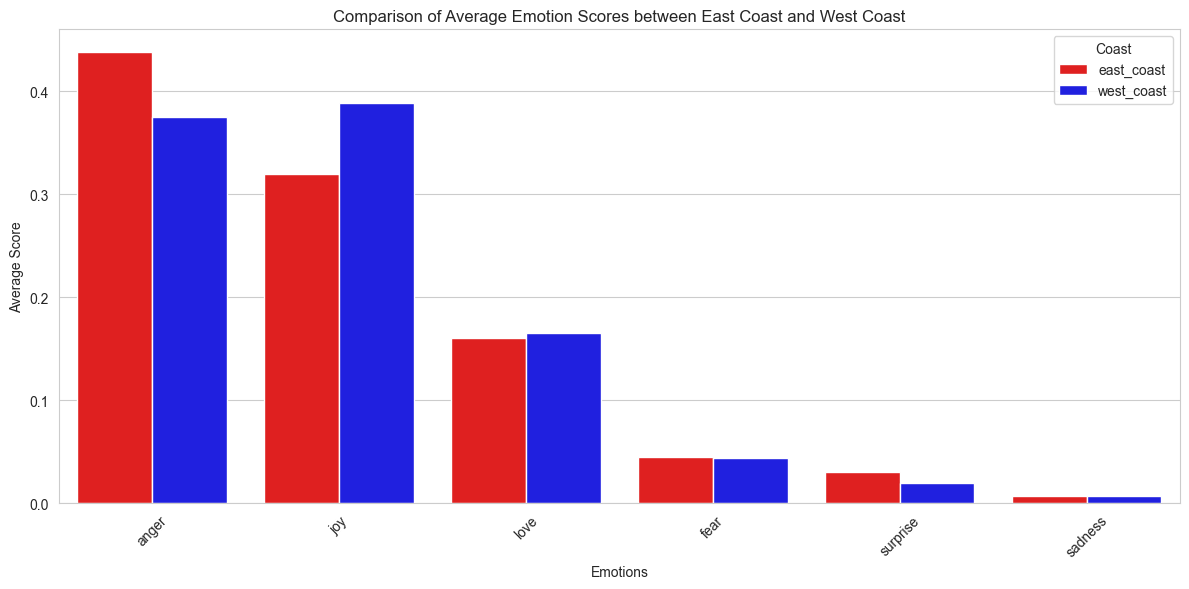

In [43]:
# Calculate the average emotion scores for each 'Coast'
average_emotions = df.groupby('Coast')[["anger", "joy", "love", "fear", "surprise", "sadness"]].mean().reset_index()

# Melt the DataFrame for seaborn compatibility (long format)
average_emotions_melted = average_emotions.melt(id_vars=['Coast'], var_name='Emotion', value_name='Average Score')

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting
sns.barplot(data=average_emotions_melted, x='Emotion', y='Average Score', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.title('Comparison of Average Emotion Scores between East Coast and West Coast')
plt.xlabel('Emotions')
plt.ylabel('Average Score')
plt.legend(title='Coast')
plt.xticks(rotation=45)
plt.tight_layout()

# Save and show the plot
plt.savefig('avg_emotions_per_coast.png')
plt.show()

<b>Let's dig a bit deeper with sentiment analysis</b>

In [53]:
# Group by release year and calculate average emotion scores
emotion_over_time = df.groupby('Release Year')[["anger", "joy", "love"]].mean().reset_index()

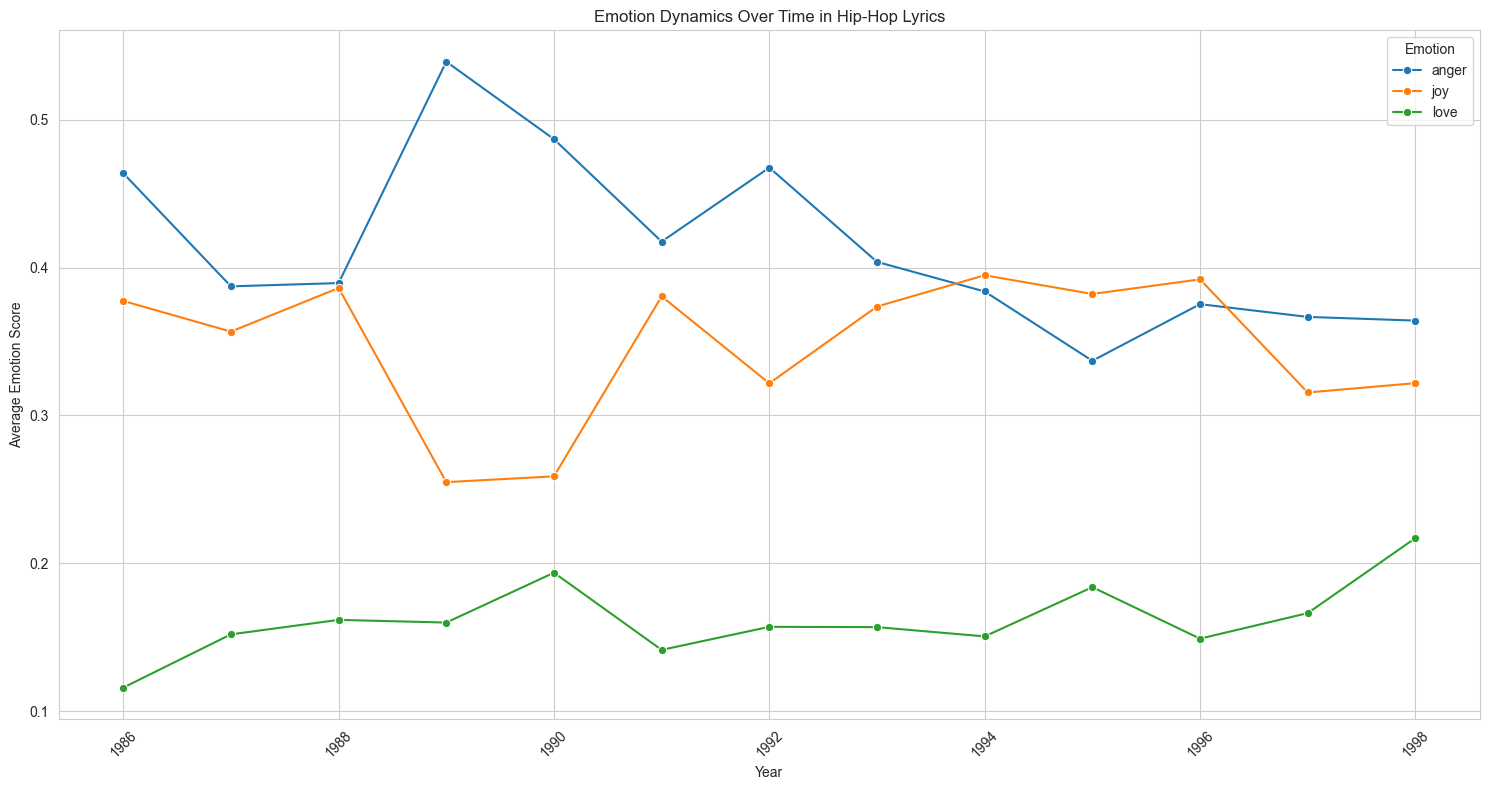

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(15, 8))

# Melt the DataFrame for seaborn compatibility (long format)
emotion_over_time_melted = emotion_over_time.melt(id_vars=['Release Year'], var_name='Emotion', value_name='Average Score')

# Plotting emotions over time
sns.lineplot(data=emotion_over_time_melted, x='Release Year', y='Average Score', hue='Emotion', marker='o')

# Adding title and labels
plt.title('Emotion Dynamics Over Time in Hip-Hop Lyrics')
plt.xlabel('Year')
plt.ylabel('Average Emotion Score')
plt.xticks(rotation=45)
plt.tight_layout()

# Save and show the plot
# plt.savefig('emotion_dynamics_over_time.png')
plt.show()

In [56]:
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,...,love,fear,surprise,sadness,anger_intensity,joy_intensity,love_intensity,fear_intensity,surprise_intensity,sadness_intensity
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.125650,0.041458,0.017698,0.009004,medium,medium,low,low,low,low
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.082604,0.092858,0.014745,0.007932,medium,medium,low,low,low,low
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.237632,0.017695,0.009742,0.005924,low,medium,low,low,low,low
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.688449,0.017647,0.006557,0.004467,low,low,high,low,low,low
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.023076,0.007259,0.001568,0.001289,low,high,low,low,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.289313,0.073188,0.013720,0.009014,low,medium,low,low,low,low
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.054806,0.027464,0.011710,0.006620,low,high,low,low,low,low
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.173832,0.054543,0.012622,0.007301,low,medium,low,low,low,low
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.002123,0.000274,0.000466,0.000374,high,low,low,low,low,low


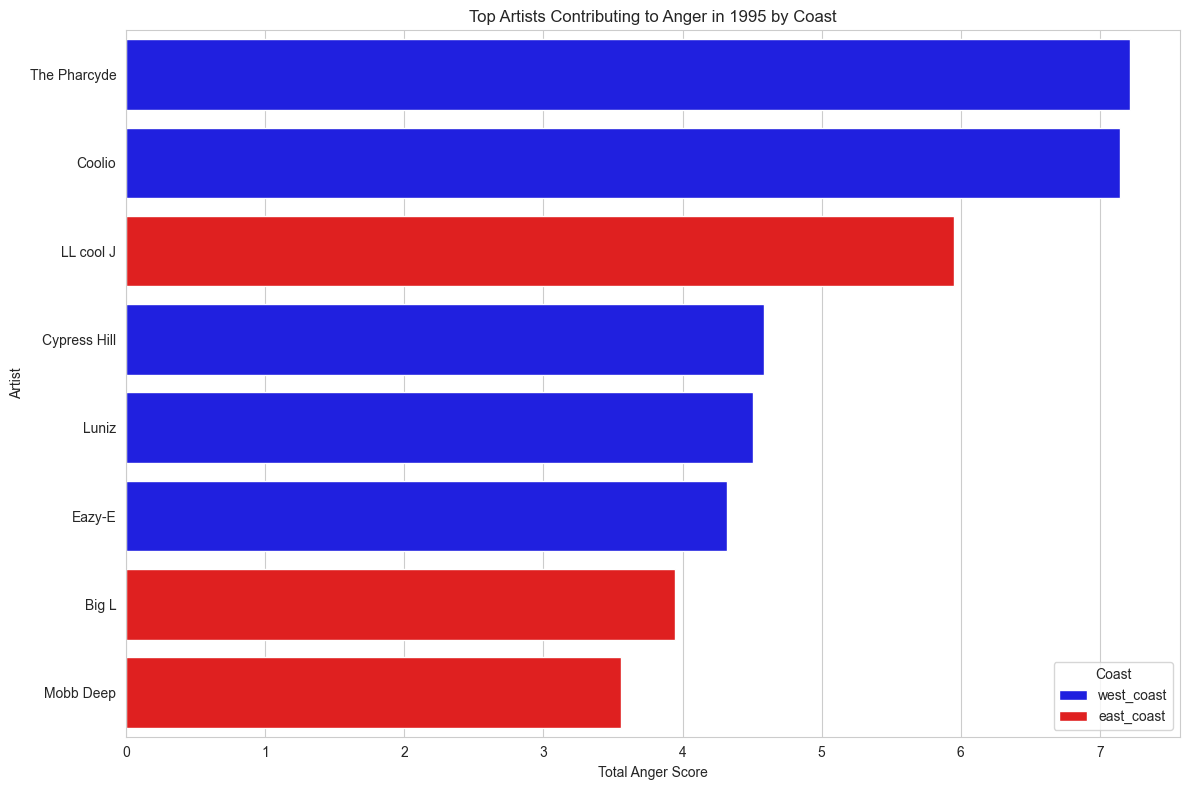

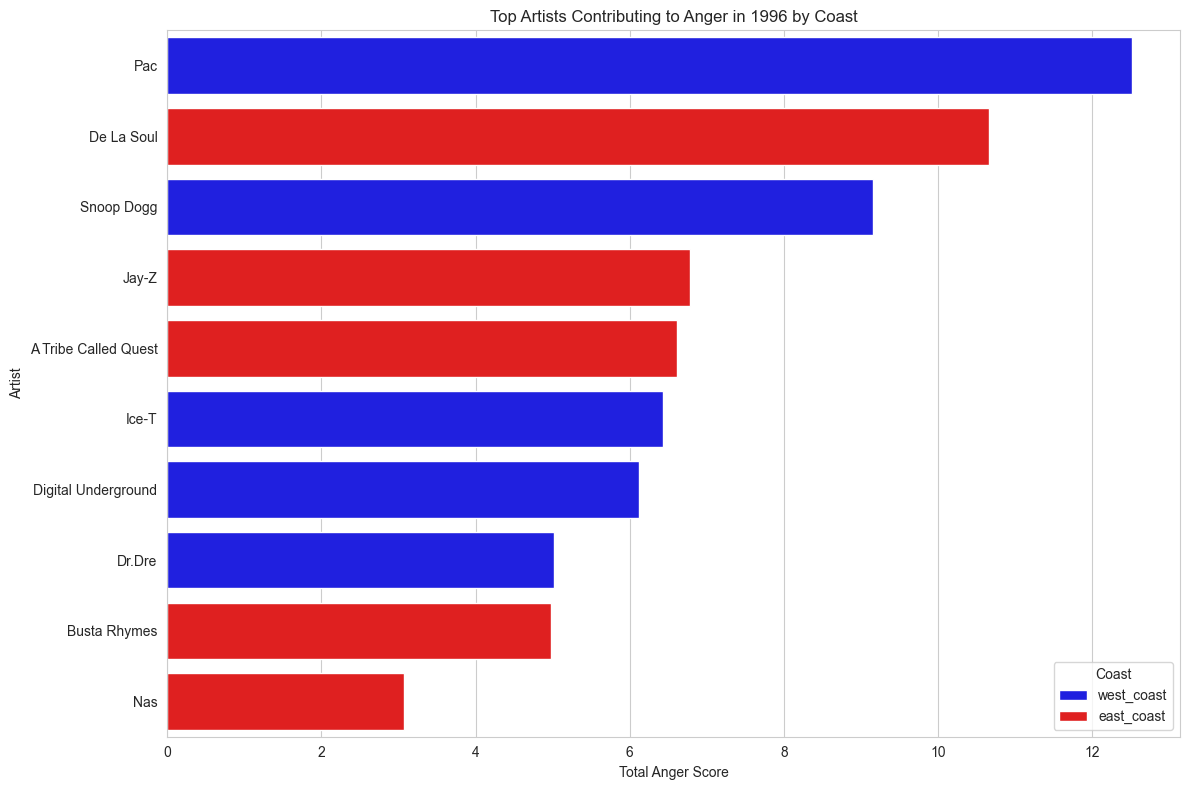

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter datasets for the years 1988 and 1989
# df_1988 = df[df['Release Year'] == 1988]
# df_1989 = df[df['Release Year'] == 1989]
df_1995 = df[df['Release Year'] == 1995]
df_1996 = df[df['Release Year'] == 1996]

# Function to group by Artist and Coast for anger scores
def get_anger_scores_by_artist(df):
    df_anger = df[['Artist', 'Coast', 'Song', 'anger']]
    artist_anger_scores = df_anger.groupby(['Coast', 'Artist'])['anger'].sum().reset_index()
    return artist_anger_scores.sort_values(by='anger', ascending=False)

# Get anger scores for each year and filter top artists for each coast
# artist_anger_scores_1988 = get_anger_scores_by_artist(df_1988)
# artist_anger_scores_1989 = get_anger_scores_by_artist(df_1989)
artist_anger_scores_1995 = get_anger_scores_by_artist(df_1995)
artist_anger_scores_1996 = get_anger_scores_by_artist(df_1996)

# top_anger_artists_1988 = artist_anger_scores_1988.groupby('Coast').head(5)
# top_anger_artists_1989 = artist_anger_scores_1989.groupby('Coast').head(5)
top_anger_artists_1995 = artist_anger_scores_1995.groupby('Coast').head(5)
top_anger_artists_1996 = artist_anger_scores_1996.groupby('Coast').head(5)

# # Plotting for 1988
# plt.figure(figsize=(12, 8))
# sns.barplot(data=top_anger_artists_1988, x='anger', y='Artist', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
# plt.xlabel('Total Anger Score')
# plt.ylabel('Artist')
# plt.title('Top Artists Contributing to Anger in 1988 by Coast')
# plt.legend(title='Coast')
# plt.tight_layout()
# plt.show()
# 
# # Plotting for 1989
# plt.figure(figsize=(12, 8))
# sns.barplot(data=top_anger_artists_1989, x='anger', y='Artist', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
# plt.xlabel('Total Anger Score')
# plt.ylabel('Artist')
# plt.title('Top Artists Contributing to Anger in 1989 by Coast')
# plt.legend(title='Coast')
# plt.tight_layout()
# plt.show()

# Plotting for 1995
plt.figure(figsize=(12, 8))
sns.barplot(data=top_anger_artists_1995, x='anger', y='Artist', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.xlabel('Total Anger Score')
plt.ylabel('Artist')
plt.title('Top Artists Contributing to Anger in 1995 by Coast')
plt.legend(title='Coast')
plt.tight_layout()
plt.show()

# Plotting for 1996
plt.figure(figsize=(12, 8))
sns.barplot(data=top_anger_artists_1996, x='anger', y='Artist', hue='Coast', palette={"east_coast": "red", "west_coast": "blue"})
plt.xlabel('Total Anger Score')
plt.ylabel('Artist')
plt.title('Top Artists Contributing to Anger in 1996 by Coast')
plt.legend(title='Coast')
plt.tight_layout()
plt.show()

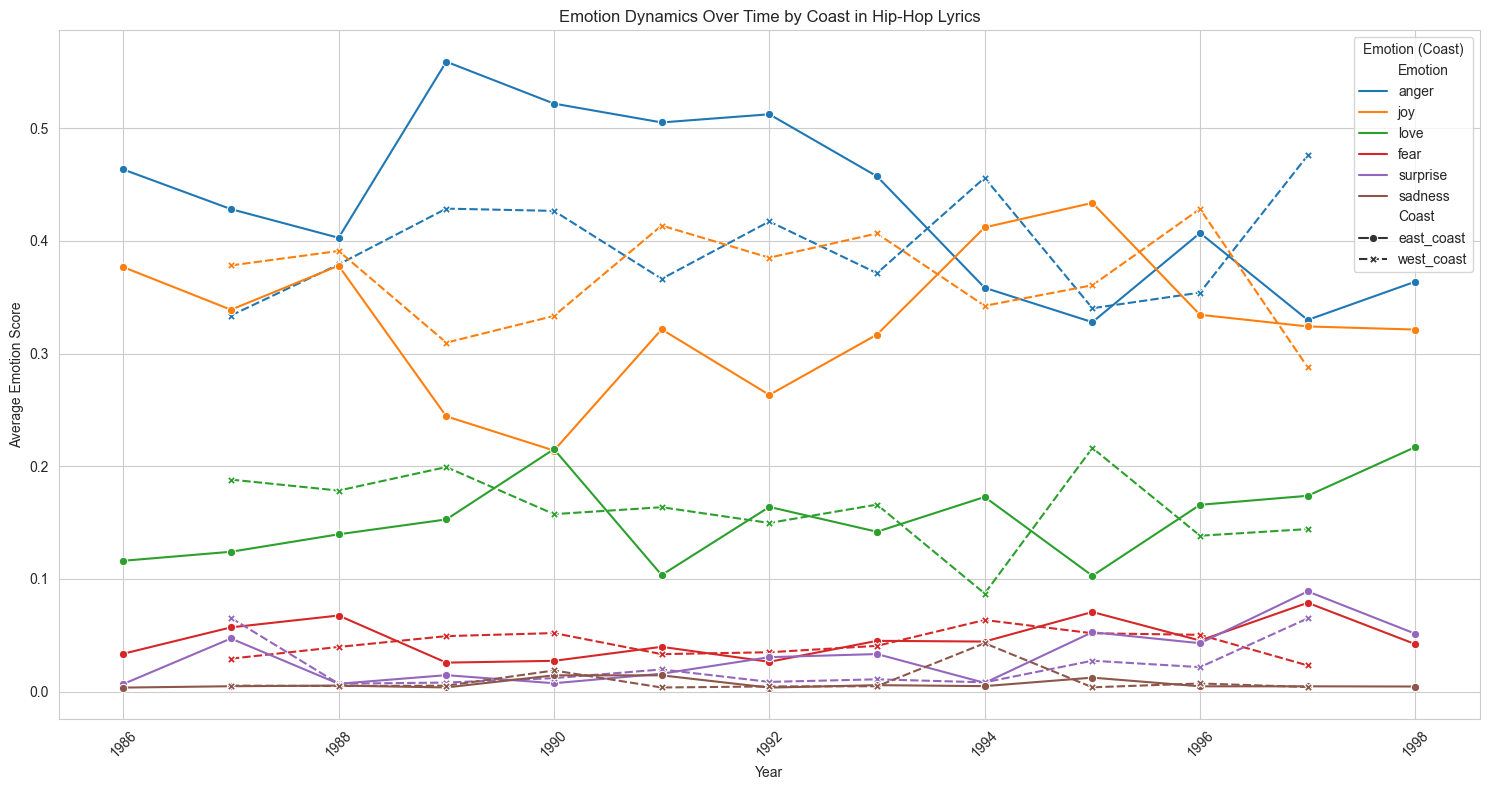

In [49]:
# Group by both release year and Coast to observe regional differences
emotion_coast_time = df.groupby(['Release Year', 'Coast'])[["anger", "joy", "love", "fear", "surprise", "sadness"]].mean().reset_index()

# Melt the DataFrame for seaborn compatibility (long format)
emotion_coast_time_melted = emotion_coast_time.melt(id_vars=['Release Year', 'Coast'], var_name='Emotion', value_name='Average Score')

# Initialize the figure
plt.figure(figsize=(15, 8))

# Plotting emotions over time, separated by Coast
sns.lineplot(data=emotion_coast_time_melted, x='Release Year', y='Average Score', hue='Emotion', style='Coast', markers=True)

# Adding title and labels
plt.title('Emotion Dynamics Over Time by Coast in Hip-Hop Lyrics')
plt.xlabel('Year')
plt.ylabel('Average Emotion Score')
plt.legend(title='Emotion (Coast)')
plt.xticks(rotation=45)
plt.tight_layout()

# Save and show the plot
# plt.savefig('emotion_dynamics_over_time_by_coast.png')
plt.show()


In [60]:
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,...,love,fear,surprise,sadness,anger_intensity,joy_intensity,love_intensity,fear_intensity,surprise_intensity,sadness_intensity
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.125650,0.041458,0.017698,0.009004,medium,medium,low,low,low,low
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.082604,0.092858,0.014745,0.007932,medium,medium,low,low,low,low
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.237632,0.017695,0.009742,0.005924,low,medium,low,low,low,low
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.688449,0.017647,0.006557,0.004467,low,low,high,low,low,low
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.023076,0.007259,0.001568,0.001289,low,high,low,low,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.289313,0.073188,0.013720,0.009014,low,medium,low,low,low,low
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.054806,0.027464,0.011710,0.006620,low,high,low,low,low,low
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.173832,0.054543,0.012622,0.007301,low,medium,low,low,low,low
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,...,0.002123,0.000274,0.000466,0.000374,high,low,low,low,low,low


In [ ]:
# Step 1: Filter the DataFrame to include only songs by the artist "Pac"
pac_songs_df = df[df['Artist'] == 'Pac'].copy()

# Step 4: Count the number of songs by "Pac" in each emotion cluster, grouped by Coast
pac_cluster_counts = pac_songs_df.groupby(['pseudo_label', 'Coast']).size().reset_index(name='Count')

# Step 5: Create a bar plot to visualize the cluster distribution by coast for "Pac"
plt.figure(figsize=(12, 8))

# Plot using Seaborn's barplot to visualize cluster counts across coasts for "Pac"
sns.barplot(data=pac_cluster_counts, x='pseudo_label', y='Count', hue='Coast', palette={'east_coast': 'red', 'west_coast': 'blue'})

# Add titles and labels
plt.title('Emotion Cluster Distribution for Artist "Pac" by East Coast and West Coast')
plt.xlabel('Emotion Cluster')
plt.ylabel('Number of Songs')
plt.legend(title='Coast')
plt.tight_layout()

# Show the plot
plt.show()